<a href="https://colab.research.google.com/github/bonareri/Machine-Learning/blob/main/brain_tumor_detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [40]:
import os
import json
from zipfile import ZipFile
from PIL import Image
import json

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

## Data Curation

In [31]:
!pip install kaggle

In [32]:
kaggle_credentials  = json.load(open("kaggle.json"))

In [33]:
#setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

## Loading Data

In [34]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [35]:
!ls

brain-mri-images-for-brain-tumor-detection.zip	kaggle.json	no	     yes
brain_tumor_dataset				meningioma.jpg	sample_data


In [36]:
# Unzip the downloaded dataset
with ZipFile("brain-mri-images-for-brain-tumor-detection.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [37]:
# List the extracted files and directories
extracted_files = os.listdir("brain_tumor_dataset")
print(extracted_files)

['no', 'yes']


In [38]:
#Checking for the total number of values per folder
yes = len(os.listdir('brain_tumor_dataset/yes'))
no = len(os.listdir('brain_tumor_dataset/no'))

print(yes, no)

155 98


## Image loading

In [15]:
# Define the path to the extracted dataset
dataset_dir = "brain_tumor_dataset"
categories = ["yes", "no"]  # 'yes' is tumor and 'no' is no tumor

# Initialize an empty list to store image data
data = []

# Load the images
for category in categories:
    category_path = os.path.join(dataset_dir, category)
    label = categories.index(category)  # 'yes' will be labeled 0, 'no' will be labeled 1
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        try:
            img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            data.append([img_array, label])
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

print(f"Loaded {len(data)} images.")


Loaded 253 images.


## Image Resize:

Resized images to 128x128.


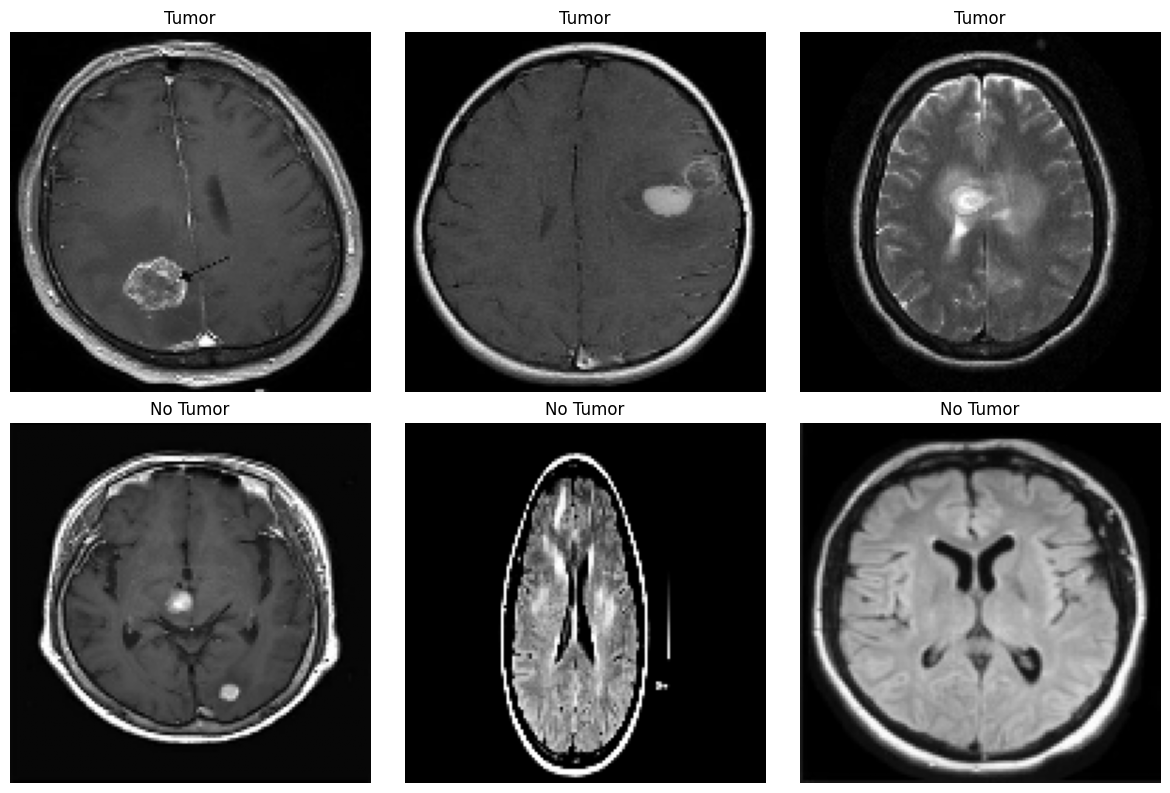

In [39]:
IMG_SIZE = 128  # Define the image size for resizing

# Resize the images
resized_data = []
for img_array, label in data:
    resized_img = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize image to 128x128
    resized_data.append([resized_img, label])

print(f"Resized images to {IMG_SIZE}x{IMG_SIZE}.")

# Show some sample resized images from both categories
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Display 3 images with tumor (category 'yes')
tumor_images = [item[0] for item in resized_data if item[1] == 0][:3]
for i, ax in enumerate(axes[0]):
    ax.imshow(tumor_images[i], cmap='gray')
    ax.set_title("Tumor")
    ax.axis('off')

# Display 3 images without tumor (category 'no')
no_tumor_images = [item[0] for item in resized_data if item[1] == 1][:3]
for i, ax in enumerate(axes[1]):
    ax.imshow(no_tumor_images[i], cmap='gray')
    ax.set_title("No Tumor")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Normalization:

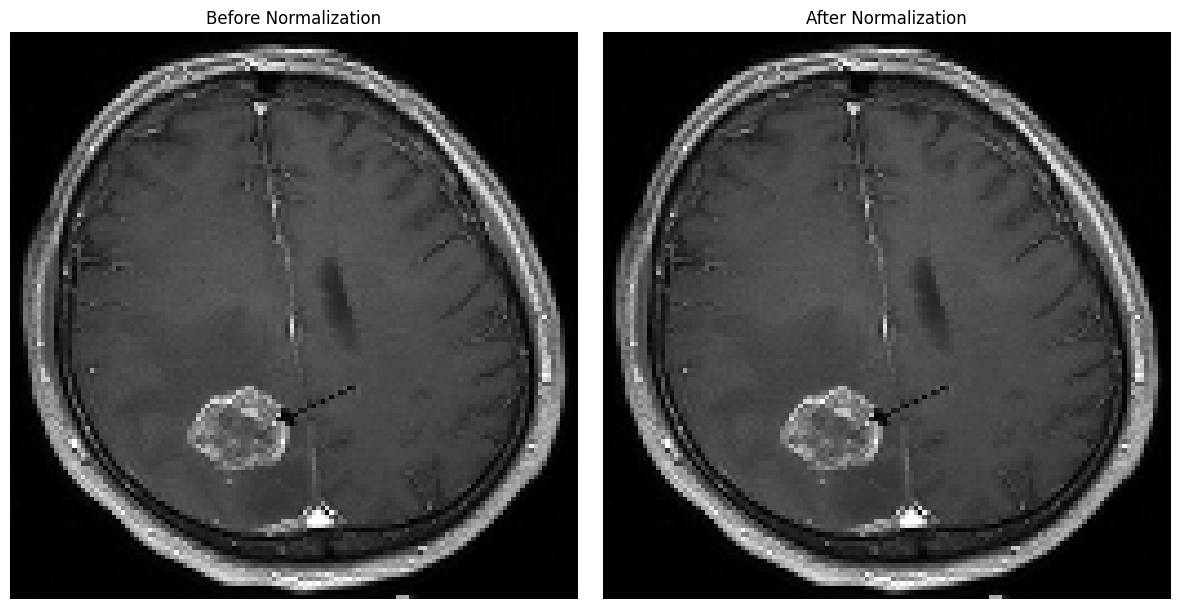

Before normalization:
0 254
After normalization:
0.0 0.996078431372549


In [41]:
# Show a sample image before and after normalization
index = 0  # Choose an image index for visualization

# Get the raw image (before normalization)
raw_image = resized_data[index][0]

# Normalize the image
normalized_image = raw_image / 255.0

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Show the raw image
axes[0].imshow(raw_image, cmap='gray')
axes[0].set_title("Before Normalization")
axes[0].axis('off')

# Show the normalized image
axes[1].imshow(normalized_image, cmap='gray')
axes[1].set_title("After Normalization")
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Before normalization:")
print(raw_image.min(), raw_image.max())  # Min and max pixel values before normalization

print("After normalization:")
print(normalized_image.min(), normalized_image.max())  # Min and max pixel values after normalization

## Data Augmentation

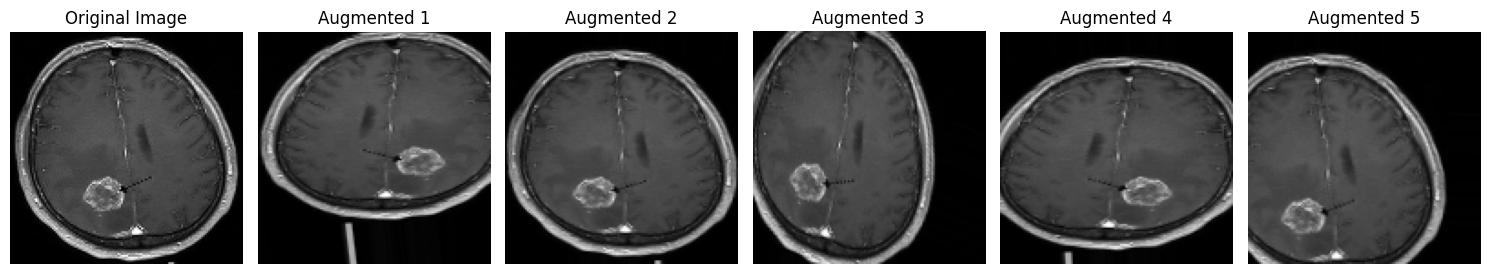

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a function to display augmented images
def display_augmented_images(image, num_images=5):
    # Create an ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Reshape the image to match the expected input for the generator
    image = image.reshape((1, IMG_SIZE, IMG_SIZE, 1))  # Reshape to (1, IMG_SIZE, IMG_SIZE, 1)

    # Generate augmented images
    i = 0
    augmented_images = []
    for batch in datagen.flow(image, batch_size=1, save_to_dir='/tmp', save_prefix='aug', save_format='jpeg'):
        augmented_images.append(batch[0])  # Store the augmented image
        i += 1
        if i >= num_images:
            break

    # Plot the original image and the augmented images
    fig, axes = plt.subplots(1, num_images + 1, figsize=(15, 6))

    # Show the original image
    axes[0].imshow(image[0, :, :, 0], cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Show augmented images
    for i, img in enumerate(augmented_images):
        axes[i + 1].imshow(img, cmap='gray')
        axes[i + 1].set_title(f"Augmented {i+1}")
        axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Select an image index and display augmented images
index = 0  # You can choose any index in the dataset
sample_image = resized_data[index][0]  # Get the raw image before augmentation
display_augmented_images(sample_image, num_images=5)

## Split the data into training and validation sets:

In [74]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming resized_data is already defined with images and labels
X = np.array([item[0] for item in resized_data]) / 255.0  # Normalize pixel values
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Reshape to (IMG_SIZE, IMG_SIZE, 1) for grayscale images
y = np.array([item[1] for item in resized_data])

# First, split data into 80% training and 20% remaining data (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Second, split the remaining data into 50% validation and 50% test (since 20% of the data is remaining)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}, Test data: {X_test.shape}")

Training data: (202, 128, 128, 1), Validation data: (25, 128, 128, 1), Test data: (26, 128, 128, 1)


## Augmentation during training:

In [45]:
# Create an ImageDataGenerator with augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a validation ImageDataGenerator (no augmentation)
val_datagen = ImageDataGenerator()

# Fit the generator on the training data
train_datagen.fit(X_train)
val_datagen.fit(X_val)

## Build the Model:

In [46]:
# Define the CNN model (using the same architecture as before)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(2, activation='softmax')  # Output layer with 2 classes (tumor or no tumor)
])


# Print the model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,939,266 (49.36 MB)

 Trainable params: 12,939,266 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

## Compile the Model:

In [47]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Train the Model:

In [48]:
# Train the model using the augmented data generators
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
    validation_steps=len(X_val) // 32
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 490ms/step - accuracy: 0.5679 - loss: 0.7897 - val_accuracy: 0.4688 - val_loss: 0.7003
Epoch 2/10
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5625 - loss: 0.6764

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.5625 - loss: 0.6764 - val_accuracy: 0.6316 - val_loss: 0.6021
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.6077 - loss: 0.6534
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6875 - loss: 0.6133 - val_accuracy: 0.5000 - val_loss: 0.6965
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6443 - loss: 0.6054 - val_accuracy: 0.7895 - val_loss: 0.5154
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5312 - loss: 0.7191
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6458 - loss: 0.6312 - val_accuracy: 0.6875 - val_loss: 0.6147
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - loss: 0.5668 - val_accuracy: 0.6316 - val_loss: 0.5897
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6629 - loss: 0.5936
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6875 - loss: 0.6247 - val_accuracy: 0.7188 - val_loss: 0.5266


## Evaluate the Model:

In [49]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7128 - loss: 0.5785
Validation loss: 0.5617
Validation accuracy: 0.7255


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step


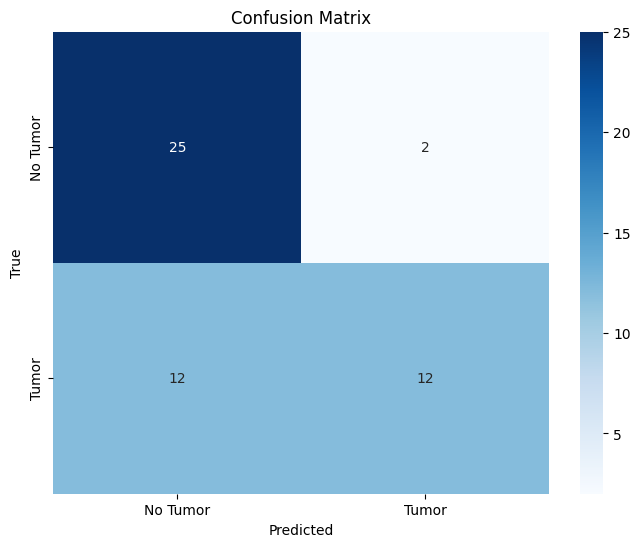

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Get the predicted classes

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


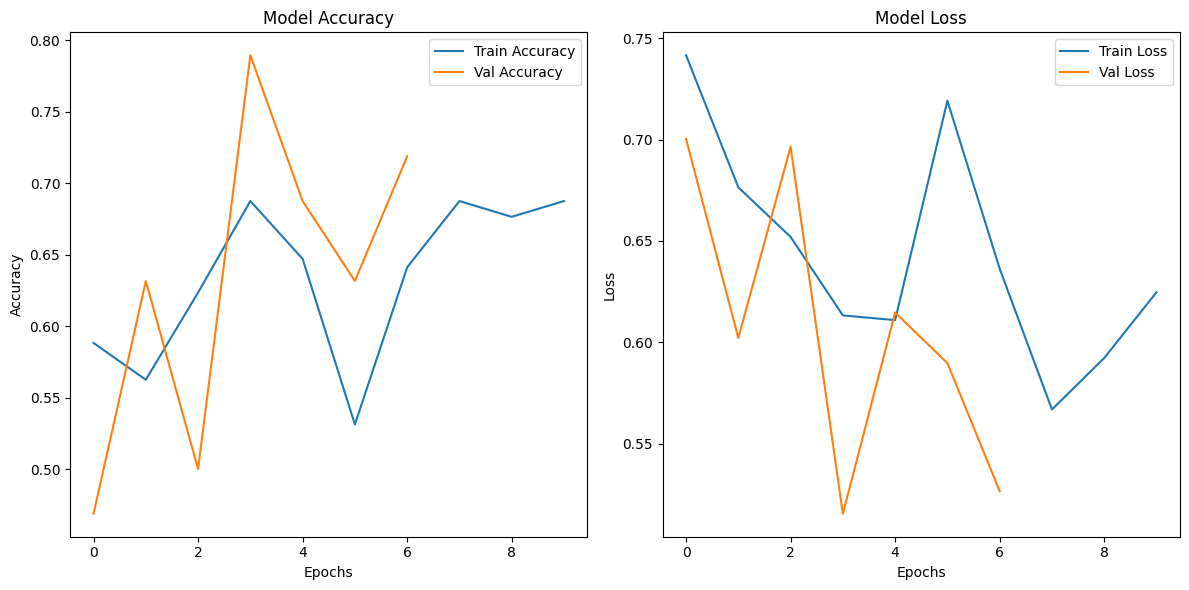

In [51]:
# Plot training & validation accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

## Model Predictions:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Prediction (probabilities): [[0.40512642 0.5948736 ]]
Predicted class: No Tumor


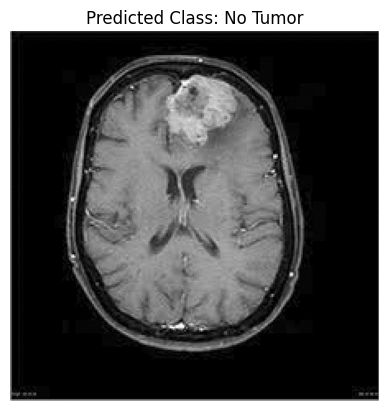

In [52]:
# Make predictions on a sample image
sample_img_path = "/content/meningioma.jpg"
sample_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)

# Resize and normalize the image
sample_img_resized = cv2.resize(sample_img, (IMG_SIZE, IMG_SIZE)) / 255.0
sample_img_resized = sample_img_resized.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Predict
prediction = model.predict(sample_img_resized)
print(f"Prediction (probabilities): {prediction}")
predicted_class = 'Tumor' if prediction[0][0] > 0.5 else 'No Tumor'
print(f"Predicted class: {predicted_class}")

# Show the image along with its predicted class
plt.imshow(sample_img, cmap='gray')  # Display the image in grayscale
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')  # Hide axis
plt.show()

## Hyperparameter Tuning

In [28]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [29]:
import keras_tuner as kt

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    # Assuming X_train is globally available or passed as a parameter
    input_shape = (128, 128, 1)  # Modify as per your input shape

    model = Sequential()

    # Add convolutional layers with hyperparameter tuning for filters
    model.add(Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
                     kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
                     kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(hp.Int('conv_3_filters', min_value=64, max_value=256, step=64),
                     kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output of the convolutional layers
    model.add(Flatten())

    # Add dense layers with hyperparameter tuning for units and dropout rate
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))  # Assuming 10 classes for classification

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


## Using Keras Tuner to Search for Best Hyperparameters

In [69]:
# Define the hyperparameter tuning search space with a new project name
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='tuner_results',
    project_name='new_cnn_tuning'  # New project name to avoid overwriting
)

Reloading Tuner from tuner_results/new_cnn_tuning/tuner0.json


In [70]:
# Start hyperparameter tuning
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Trial 56 Complete [00h 00m 12s]
val_accuracy: 0.8235294222831726

Best val_accuracy So Far: 0.843137264251709
Total elapsed time: 00h 16m 59s


## Build and Train the Model with Best Hyperparameters

In [71]:
# Build the model with the best hyperparameters
model = build_model(hp=tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters)

# Train the model with the best hyperparameters
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - accuracy: 0.4087 - loss: 1.5390 - val_accuracy: 0.5294 - val_loss: 0.8167
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7084 - loss: 0.6296 - val_accuracy: 0.8235 - val_loss: 0.4808
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7456 - loss: 0.5895 - val_accuracy: 0.8039 - val_loss: 0.4589
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7815 - loss: 0.4936 - val_accuracy: 0.7647 - val_loss: 0.5733
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7533 - loss: 0.5533 - val_accuracy: 0.8431 - val_loss: 0.4350
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8627 - loss: 0.4076 - val_accuracy: 0.8235 - val_loss: 0.4784
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8906 - loss: 0.3012 - val_accuracy: 0.8039 - val_loss: 0.4869
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8858 - loss: 0.2875 - val_accuracy: 0.8039 - val_loss: 0.4844

## Evaluate the Model on Test Data

In [77]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_acc}')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7600 - loss: 0.8072
Validation Accuracy: 0.7599999904632568
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8846 - loss: 0.3204
Test Accuracy: 0.8846153616905212
